In [2]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np

class NpzRegressionDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, np.ndarray):
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X
        self.y = torch.from_numpy(y).float()
        # y shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [4]:
import numpy as np
import torch

# record_index
# vector_index
# diff_indices
# diff_values
# cost

json_diffs = np.load("../i_vectors_diffs.npz")

# raw_inputs = np.array(json_diffs["diff_values"], dtype=int)

input_data = np.log(json_diffs["diff_values"]+1e-8)
# input_data = json_diffs["diff_values"]
cost = -np.log(json_diffs["cost"])

In [ ]:
import torch
from sklearn.model_selection import train_test_split

def transform_schedule(x_int, mean=None, std=None, eps=1e-6):
    """
    스케줄 파라미터 int 텐서를 log-scale + zero-flag로 변환

    Args:
        x_int: (B, D) int 텐서. 예: 0, 1, 2, 4, 8, ..., 1024
        mean, std: (1, D) 형태의 텐서. None이면 입력에서 계산해서 반환.
        eps: 분산 0 방지용 작은 값.

    Returns:
        x_cont: (B, 2*D) float 텐서. [v_norm, is_zero] concat
        mean, std: (1, D) float 텐서. 나중에 validation/test에도 reuse
    """
    # int → float
    x_int = torch.tensor(x_int)
    x = x_int.to(torch.float32)

    # zero flag
    is_zero = (x_int == 0).to(torch.float32)  # (B, D)

    # log2 변환 (0은 일단 0으로 두고 mask)
    v = torch.zeros_like(x, dtype=torch.float32)  # (B, D)
    mask = (x_int > 0)
    v[mask] = torch.log2(x[mask])

    # mean / std 없으면 전체 batch 기준으로 계산 (보통은 train 전체로 미리 계산)
    if mean is None or std is None:
        mean = v.mean(dim=0, keepdim=True)           # (1, D)
        std = v.std(dim=0, keepdim=True) + eps       # (1, D)

    # 정규화
    v_norm = (v - mean) / std   # (B, D)

    # v_norm과 is_zero concat → (B, 2D)
    x_cont = torch.cat([v_norm, is_zero], dim=-1)

    return x_cont, mean, std



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dim=128):
        """
        input_dim: 2 * D (v_norm + is_zero concat한 차원)
        latent_dim: latent space 차원
        hidden_dim: MLP hidden 크기
        """
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            
            # 출력은 연속값이니까 activation 없이 그대로
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    x, x_recon: (B, input_dim)
    mu, logvar: (B, latent_dim)

    beta: KL 가중치 (β-VAE 스타일로 조절)
    """
    # reconstruction loss: MSE
    recon_loss = F.mse_loss(x_recon, x, reduction="mean")

    # KL divergence: D_KL(q(z|x) || N(0, I))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    loss = recon_loss + beta * kl
    return loss, recon_loss, kl




In [ ]:
from sklearn.metrics import r2_score
import torch
# 예시 세팅

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# input_data, mean, std = transform_schedule(json_diffs["diff_values"])
X_train, X_val, y_train, y_val = train_test_split(
    input_data, cost, test_size=0.2, random_state=42
)
train_dataset = NpzRegressionDataset(X_train, y_train)
val_dataset   = NpzRegressionDataset(X_val,   y_val)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)



input_dim = X_train.shape[-1]
latent_dim = 16
hidden_dim = 256




vae = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)


# train_data: (N, D) int 텐서라고 가정
# train_data = torch.randint(low=0, high=1025, size=(1024, D))  # 예시용 dummy

# 전처리용 mean/std 미리 계산
# with torch.no_grad():
#     _x_cont, mean, std = transform_schedule(X_train.to(device))

beta = 0.05
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# 간단한 에폭 루프 예시
vae.train()
for epoch in range(1001):
    # 여기서는 그냥 전체를 한 번에 돌린다고 가정 (실제로는 DataLoader로 배치 쪼개기)
    for x_batch in train_loader:
        x_batch = x_batch[0].to(device)  # (N, D)
    
        # x_cont, _, _ = transform_schedule(x_batch, mean=mean, std=std)  # (N, 2D)

        x_recon, mu, logvar, z = vae(x_batch)

        loss, recon_loss, kl = vae_loss(x_recon, x_batch, mu, logvar, beta=beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for x_batch in val_loader:
        x_batch = x_batch[0].to(device)
        x_recon, mu, logvar, z = vae(x_batch)
        val_loss, val_recon_loss, val_kl = vae_loss(x_recon, x_batch, mu, logvar, beta=beta)
        val_r2 = r2_score(x_batch.detach().cpu().numpy(), x_recon.detach().cpu().numpy())

    if epoch % 20 == 0:
        print(f"epoch {epoch}: loss={loss.item():.4f}, recon={recon_loss.item():.4f}, kl={kl.item():.4f}")
        print(f"epoch {epoch}: val loss={val_loss.item():.4f}, val recon={val_recon_loss.item():.4f}, val kl={val_kl.item():.4f}")
        
        print(val_r2)


epoch 0: loss=11.9906, recon=11.9584, kl=0.6430
epoch 0: val loss=11.0599, val recon=10.9937, val kl=1.3233
-0.7601570259940512
epoch 20: loss=0.8513, recon=0.7538, kl=1.9497
epoch 20: val loss=0.8904, val recon=0.7886, val kl=2.0356
0.1660464285443211
epoch 40: loss=0.7267, recon=0.6391, kl=1.7526
epoch 40: val loss=0.7530, val recon=0.6650, val kl=1.7598
0.26766861255307206
epoch 60: loss=0.6331, recon=0.5538, kl=1.5859
epoch 60: val loss=0.6646, val recon=0.5834, val kl=1.6234
0.34181852575342453
epoch 80: loss=0.5917, recon=0.5133, kl=1.5675
epoch 80: val loss=0.5826, val recon=0.5047, val kl=1.5575
0.4149198488946526
epoch 100: loss=0.4779, recon=0.4039, kl=1.4804
epoch 100: val loss=0.5018, val recon=0.4261, val kl=1.5144
0.49136396027211
epoch 120: loss=0.4286, recon=0.3564, kl=1.4431
epoch 120: val loss=0.4581, val recon=0.3838, val kl=1.4872
0.5263530931283911
epoch 140: loss=0.3837, recon=0.3114, kl=1.4451
epoch 140: val loss=0.4072, val recon=0.3337, val kl=1.4693
0.57336866

KeyboardInterrupt: 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    input_data, cost, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

train_dataset = NpzRegressionDataset(X_train_scaled, y_train)
val_dataset   = NpzRegressionDataset(X_val_scaled,   y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

## Step 2: 개선된 모델 구조 및 하이퍼파라미터

**개선 전략:**
1. **모델 구조**: 더 깊고 넓은 네트워크 + Batch Normalization + Dropout
2. **Loss 함수**: 평활화된 L1 손실(Huber Loss) + 가중치 조정
3. **하이퍼파라미터**: 
   - 더 큰 hidden/latent 차원
   - 학습률 스케줄링 (Cosine Annealing)
   - Gradient Clipping
   - Early Stopping
4. **정규화**: Label Smoothing, Mixup 데이터 증강 고려

In [66]:
import torch.nn as nn

# 개선된 VAE 모델 v2 (Posterior Collapse 방지)
class ImprovedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=1024, latent_dim=64, activation="gelu", 
                 dropout=0.1, use_bn=True, use_layer_norm=False, use_residual=True):
        """
        Representation 학습에 최적화된 VAE v2
        - Posterior collapse 방지를 위한 구조 개선
        """
        super(ImprovedVAE, self).__init__()
        
        self.use_residual = use_residual
        self.latent_dim = latent_dim
        
        # Activation 선택
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'elu': nn.ELU(),
            'leakyrelu': nn.LeakyReLU(0.2),
            'silu': nn.SiLU(),
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation: {activation}")
        self.activation = activations[activation]
        
        # Normalization 선택
        def get_norm(dim):
            if use_layer_norm:
                return nn.LayerNorm(dim)
            elif use_bn:
                return nn.BatchNorm1d(dim)
            else:
                return nn.Identity()
        
        # ===== Encoder =====
        self.enc_input = nn.Linear(input_dim, hidden_dim)
        self.enc_norm1 = get_norm(hidden_dim)
        self.enc_drop1 = nn.Dropout(dropout)
        
        self.enc_hidden1 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_norm2 = get_norm(hidden_dim)
        self.enc_drop2 = nn.Dropout(dropout)
        
        self.enc_hidden2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.enc_norm3 = get_norm(hidden_dim // 2)
        self.enc_drop3 = nn.Dropout(dropout)
        
        self.enc_hidden3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.enc_norm4 = get_norm(hidden_dim // 4)
        
        # Latent space parameters
        self.fc_mean = nn.Linear(hidden_dim // 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 4, latent_dim)
        
        # Residual projection
        self.res_proj1 = nn.Linear(hidden_dim, hidden_dim // 2) if use_residual else None
        
        # ===== Decoder (대칭 구조) =====
        self.dec_input = nn.Linear(latent_dim, hidden_dim // 4)
        self.dec_norm1 = get_norm(hidden_dim // 4)
        self.dec_drop1 = nn.Dropout(dropout)
        
        self.dec_hidden1 = nn.Linear(hidden_dim // 4, hidden_dim // 2)
        self.dec_norm2 = get_norm(hidden_dim // 2)
        self.dec_drop2 = nn.Dropout(dropout)
        
        self.dec_hidden2 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.dec_norm3 = get_norm(hidden_dim)
        self.dec_drop3 = nn.Dropout(dropout)
        
        self.dec_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_norm4 = get_norm(hidden_dim)
        
        self.dec_output = nn.Linear(hidden_dim, input_dim)
        
        # Weight initialization
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def encode(self, x):
        h = self.enc_input(x)
        h = self.enc_norm1(h)
        h = self.activation(h)
        h = self.enc_drop1(h)
        
        h_res = h
        h = self.enc_hidden1(h)
        h = self.enc_norm2(h)
        h = self.activation(h)
        if self.use_residual:
            h = h + h_res
        h = self.enc_drop2(h)
        
        if self.use_residual and self.res_proj1 is not None:
            h_res = self.res_proj1(h)
        h = self.enc_hidden2(h)
        h = self.enc_norm3(h)
        h = self.activation(h)
        h = self.enc_drop3(h)
        
        h = self.enc_hidden3(h)
        h = self.enc_norm4(h)
        h = self.activation(h)
        
        return self.fc_mean(h), self.fc_logvar(h)
    
    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        else:
            return mean
    
    def decode(self, z):
        h = self.dec_input(z)
        h = self.dec_norm1(h)
        h = self.activation(h)
        h = self.dec_drop1(h)
        
        h = self.dec_hidden1(h)
        h = self.dec_norm2(h)
        h = self.activation(h)
        h = self.dec_drop2(h)
        
        h = self.dec_hidden2(h)
        h = self.dec_norm3(h)
        h = self.activation(h)
        h = self.dec_drop3(h)
        
        h_res = h
        h = self.dec_hidden3(h)
        h = self.dec_norm4(h)
        h = self.activation(h)
        if self.use_residual:
            h = h + h_res
        
        return self.dec_output(h)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decode(z)
        return recon_x, mean, logvar, z
    
    def get_latent(self, x):
        mean, logvar = self.encode(x)
        return mean


# β-VAE Loss with Free Bits (Posterior Collapse 방지)
def beta_vae_loss_free_bits(recon_x, x, mean, logvar, beta=1.0, free_bits=0.5, recon_type='mse'):
    """
    β-VAE Loss with Free Bits
    
    Free bits: 각 latent dimension이 최소한 free_bits만큼의 정보를 유지하도록 함
    이를 통해 posterior collapse 방지
    """
    batch_size = x.size(0)
    
    # Reconstruction loss
    if recon_type == 'mse':
        recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    elif recon_type == 'huber':
        recon_loss = F.smooth_l1_loss(recon_x, x, reduction='sum', beta=1.0) / batch_size
    else:
        recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    
    # KL Divergence per dimension with free bits
    # KL = -0.5 * (1 + logvar - mean^2 - exp(logvar))
    kl_per_dim = -0.5 * (1 + logvar - mean.pow(2) - logvar.exp())  # (batch, latent_dim)
    kl_per_dim = kl_per_dim.mean(dim=0)  # (latent_dim,)
    
    # Free bits: max(kl, free_bits) for each dimension
    # kl_per_dim = torch.clamp(kl_per_dim)
    kl_loss = kl_per_dim.mean()
    
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss



In [67]:
# 개선된 Loss 함수 (Huber Loss + 동적 가중치)
def improved_vae_loss(beta, recon_x, mean, logvar, x, cost_pred=None, y=None, 
                      huber_delta=1.0):
    
    b_recon, b_kl, b_reg = beta

    # Reconstruction loss - Huber Loss (이상치에 강함)
    
    # recon_loss = F.smooth_l1_loss(recon_x, x, reduction='sum', beta=huber_delta)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    recon_loss = b_recon * recon_loss
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    KLD = b_kl * KLD

    if cost_pred is not None:
        # Regression loss - Huber Loss
        reg_loss = F.smooth_l1_loss(cost_pred, y, reduction='sum', beta=huber_delta)
        reg_loss = b_reg * reg_loss
        return recon_loss, KLD, reg_loss

    return recon_loss, KLD, 0.0

# Cosine Annealing with Warm Restarts
def cosine_annealing_with_warmup(epoch, num_epochs, beta_range, warmup_epochs=10):
    beta_start, beta_end = beta_range
    if epoch < warmup_epochs:
        # Warmup period
        beta = beta_start + (beta_end - beta_start) * (epoch / warmup_epochs)
    else:
        # Cosine annealing
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        beta = beta_end * 0.5 * (1 + np.cos(np.pi * progress))
        beta = max(beta, beta_start)
    return beta

In [69]:
# 범용 인코더를 위한 VAE 학습 v8 (KL 50+ 목표)
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("=== VAE 학습 v8 - 범용 인코더 (KL 50+ 목표) ===\n")

num_epochs = 500
input_dim = X_train.shape[1]

# ===== 더 높은 KL 목표 + 균등한 latent 활용 =====
config = {
    'hidden_dim': 256,
    'latent_dim': 64,
    'activation': 'gelu',
    'dropout': 0.1,
    'use_bn': True,
    'use_layer_norm': False,
    'use_residual': True,
    
    # 더 높은 KL을 위한 설정
    'lr': 5e-4,
    'weight_decay': 1e-5,
    'beta_max': 2.0,           # β 더 증가! (1.0 -> 2.0)
    'beta_warmup': 80,         # warmup 기간 증가
    'free_bits': 0.9,          # free bits 증가 (차원당 최소 0.9 bit)
    'recon_type': 'mse',
}

# Target: KL ~ 58+ (64 * 0.9)
print(f"목표 KL 범위: {config['latent_dim'] * config['free_bits']:.1f} ~ {config['latent_dim'] * 1.2:.1f}")

# 모델 초기화
model = ImprovedVAE(
    input_dim=input_dim, 
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim'],
    activation=config['activation'],
    dropout=config['dropout'],
    use_bn=config['use_bn'],
    use_layer_norm=config['use_layer_norm'],
    use_residual=config['use_residual'],
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Beta max: {config['beta_max']}, Free bits: {config['free_bits']}")
print()

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['lr'], 
    weight_decay=config['weight_decay']
)

# OneCycleLR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=config['lr'] * 5,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.15,
    anneal_strategy='cos'
)

beta = 1e-05

# Early stopping
best_val_loss = float('inf')
patience = 60
patience_counter = 0
best_model_state = None
best_epoch = 0

# 학습 이력
history = {
    'train_loss': [], 'val_loss': [],
    'train_recon': [], 'val_recon': [],
    'train_kl': [], 'val_kl': [],
    'beta': [], 'lr': []
}

for epoch in range(num_epochs):

    # --- Train ---
    model.train()
    train_loss = 0.0
    train_recon_loss = 0.0
    train_kl_loss = 0.0

    for xb, _ in train_loader:
        xb = xb.to(device)

        recon_x, mean, logvar, z = model(xb)
        loss, recon_loss, kl_loss = beta_vae_loss_free_bits(
            recon_x, xb, mean, logvar, 
            beta=beta, 
            # free_bits=config['free_bits'],
            recon_type=config['recon_type']
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_recon_loss += recon_loss.item() * xb.size(0)
        train_kl_loss += kl_loss.item() * xb.size(0)
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_dataset)
    train_recon_loss /= len(train_dataset)
    train_kl_loss /= len(train_dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0

    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            recon_x, mean, logvar, z = model(xb)
            loss, recon_loss, kl_loss = beta_vae_loss_free_bits(
                recon_x, xb, mean, logvar, 
                beta=beta, 
                free_bits=config['free_bits'],
                recon_type=config['recon_type']
            )
            val_recon_loss += recon_loss.item() * xb.size(0)
            val_kl_loss += kl_loss.item() * xb.size(0)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_dataset)
    val_recon_loss /= len(val_dataset)
    val_kl_loss /= len(val_dataset)

    # 이력 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_recon'].append(train_recon_loss)
    history['val_recon'].append(val_recon_loss)
    history['train_kl'].append(train_kl_loss)
    history['val_kl'].append(val_kl_loss)
    history['beta'].append(beta)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    # Early stopping - warmup 이후부터
    if epoch >= config['beta_warmup']:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
        else:
            patience_counter += 1

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train - Recon: {train_recon_loss:.4f}, KL: {train_kl_loss:.4f}")
        print(f"  Val   - Recon: {val_recon_loss:.4f}, KL: {val_kl_loss:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}, β: {beta:.4f}")
        print()

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 최고 모델 복원
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n최고 검증 Total Loss: {best_val_loss:.4f} (epoch {best_epoch})")
    print(f"최종 Val Recon: {history['val_recon'][best_epoch-1]:.4f}, Val KL: {history['val_kl'][best_epoch-1]:.4f}")


=== VAE 학습 v8 - 범용 인코더 (KL 50+ 목표) ===

목표 KL 범위: 57.6 ~ 76.8
Device: cuda
Model parameters: 278,944
Beta max: 2.0, Free bits: 0.9

Epoch [100/500]
  Train - Recon: 3.9080, KL: 5.9105
  Val   - Recon: 2.4126, KL: 5.7623
  LR: 0.002479, β: 0.0000

Epoch [200/500]
  Train - Recon: 2.5508, KL: 7.4153
  Val   - Recon: 1.5339, KL: 7.2248
  LR: 0.002003, β: 0.0000

Epoch [300/500]
  Train - Recon: 2.1507, KL: 8.1320
  Val   - Recon: 1.2827, KL: 7.9394
  LR: 0.001134, β: 0.0000

Epoch [400/500]
  Train - Recon: 1.8892, KL: 8.3568
  Val   - Recon: 1.1671, KL: 8.1335
  LR: 0.000326, β: 0.0000

Epoch [500/500]
  Train - Recon: 1.8785, KL: 8.3869
  Val   - Recon: 1.1204, KL: 8.1787
  LR: 0.000000, β: 0.0000


최고 검증 Total Loss: 1.1190 (epoch 499)
최종 Val Recon: 1.1189, Val KL: 8.1828


In [70]:
from sklearn.metrics import r2_score
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    recon_x, mean, logvar, z = model(X_val_tensor)

val_r2 = r2_score(X_val_tensor.cpu(), recon_x.cpu())
print(val_r2)

-5.423687922547893


=== 개선된 VAE 성능 평가 (Representation 품질) ===

훈련 데이터 Reconstruction MSE: 0.032589
검증 데이터 Reconstruction MSE: 0.059478

Latent space 통계:
  Mean of means: 0.0002
  Std of means: 0.8173
  Mean abs: 0.6659


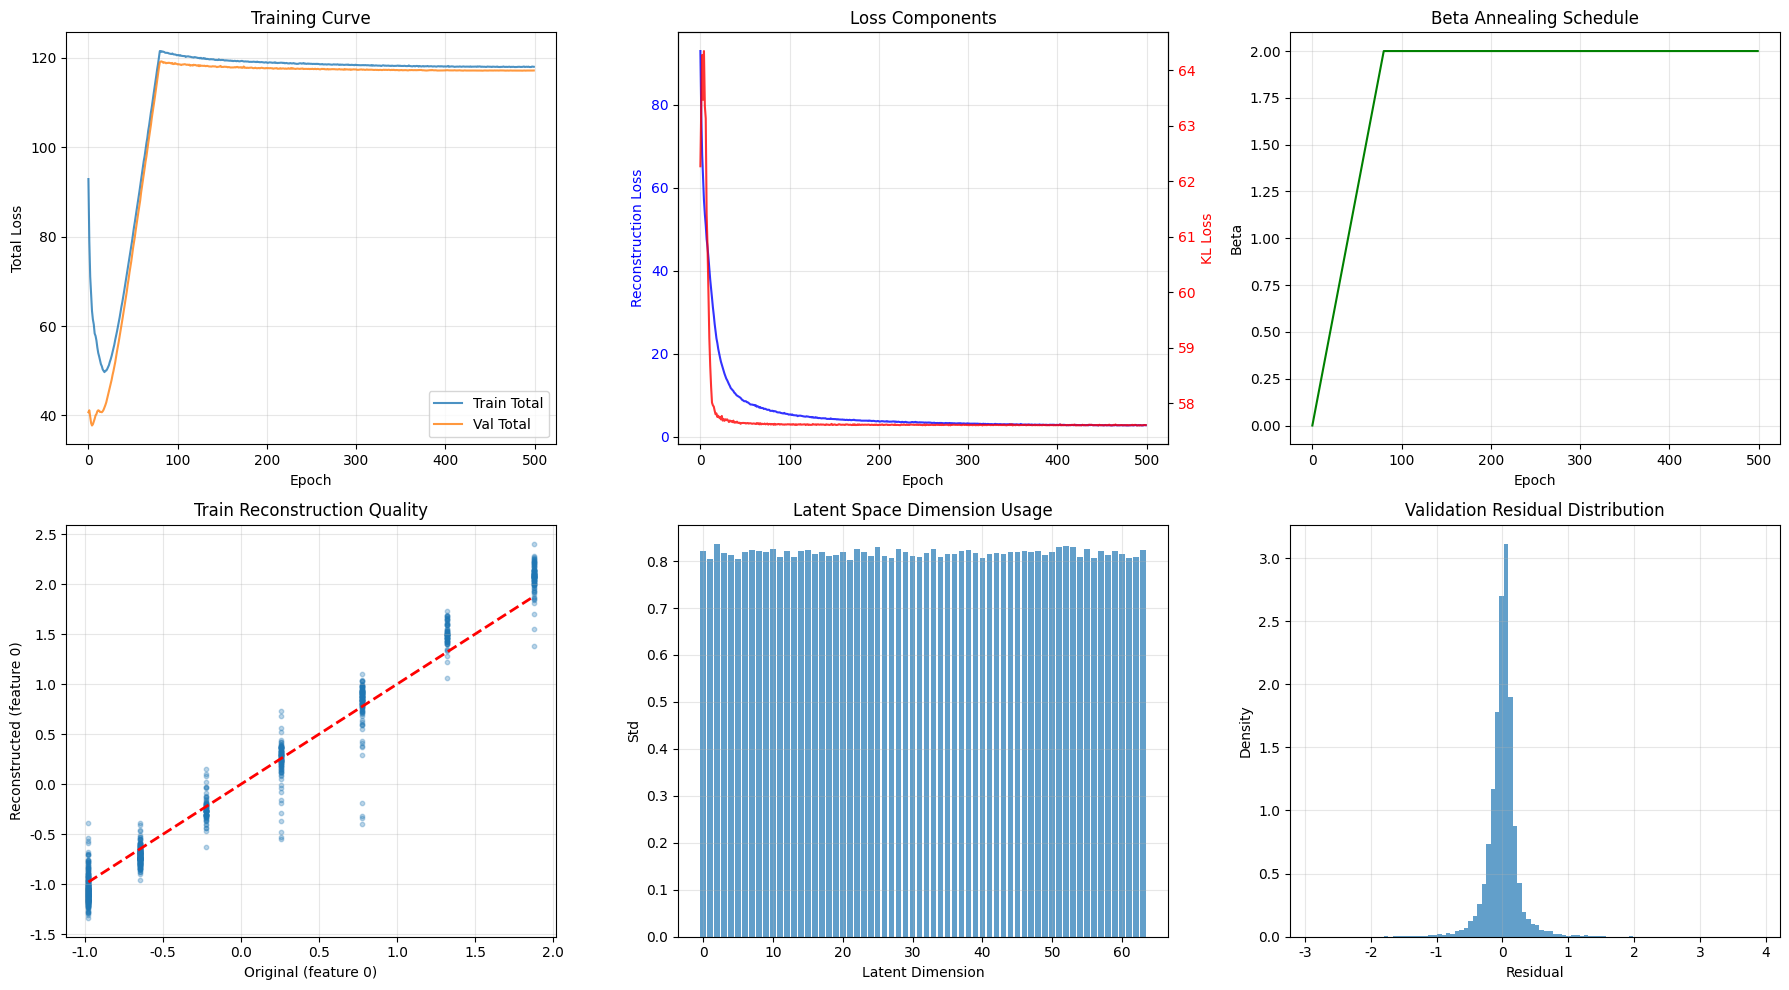


=== Representation 품질 지표 ===
Active latent units (std > 0.1): 64/64 (100.0%)
Latent space coverage (mean std): 0.8172


In [31]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 개선된 모델 성능 평가 (representation 중심)
print("=== 개선된 VAE 성능 평가 (Representation 품질) ===\n")

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

model.eval()

# 1. 재구성 품질 평가
train_recons, train_inputs, train_latents = [], [], []
with torch.no_grad():
    for xb, _ in train_loader:
        xb = xb.to(device)
        recon_x, mean, logvar, z = model(xb)
        train_recons.append(recon_x.cpu().numpy())
        train_inputs.append(xb.cpu().numpy())
        train_latents.append(mean.cpu().numpy())  # mean을 representation으로 사용

train_recons = np.concatenate(train_recons)
train_inputs = np.concatenate(train_inputs)
train_latents = np.concatenate(train_latents)
train_recon_mse = mean_squared_error(train_inputs, train_recons)

val_recons, val_inputs, val_latents = [], [], []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        recon_x, mean, logvar, z = model(xb)
        val_recons.append(recon_x.cpu().numpy())
        val_inputs.append(xb.cpu().numpy())
        val_latents.append(mean.cpu().numpy())

val_recons = np.concatenate(val_recons)
val_inputs = np.concatenate(val_inputs)
val_latents = np.concatenate(val_latents)
val_recon_mse = mean_squared_error(val_inputs, val_recons)

print(f"훈련 데이터 Reconstruction MSE: {train_recon_mse:.6f}")
print(f"검증 데이터 Reconstruction MSE: {val_recon_mse:.6f}")

# 2. Latent space 분석
print(f"\nLatent space 통계:")
print(f"  Mean of means: {train_latents.mean():.4f}")
print(f"  Std of means: {train_latents.std():.4f}")
print(f"  Mean abs: {np.abs(train_latents).mean():.4f}")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 학습 곡선
axes[0, 0].plot(history['train_loss'], label='Train Total', alpha=0.8)
axes[0, 0].plot(history['val_loss'], label='Val Total', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Training Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss 컴포넌트
ax2 = axes[0, 1]
ax2.plot(history['train_recon'], label='Recon Loss', alpha=0.8, color='blue')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Reconstruction Loss', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2_twin = ax2.twinx()
ax2_twin.plot(history['train_kl'], label='KL Loss', alpha=0.8, color='red')
ax2_twin.set_ylabel('KL Loss', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2.set_title('Loss Components')
ax2.grid(True, alpha=0.3)

# 3. β annealing schedule
axes[0, 2].plot(history['beta'], label='Beta', color='green')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Beta')
axes[0, 2].set_title('Beta Annealing Schedule')
axes[0, 2].grid(True, alpha=0.3)

# 4. 재구성 비교 (훈련)
sample_idx = np.random.choice(len(train_inputs), min(1000, len(train_inputs)), replace=False)
axes[1, 0].scatter(train_inputs[sample_idx, 0], train_recons[sample_idx, 0], alpha=0.3, s=10)
min_val, max_val = train_inputs[:, 0].min(), train_inputs[:, 0].max()
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1, 0].set_xlabel('Original (feature 0)')
axes[1, 0].set_ylabel('Reconstructed (feature 0)')
axes[1, 0].set_title('Train Reconstruction Quality')
axes[1, 0].grid(True, alpha=0.3)

# 5. Latent space 분포 (각 차원의 분포)
latent_means = train_latents.mean(axis=0)
latent_stds = train_latents.std(axis=0)
axes[1, 1].bar(range(len(latent_means)), latent_stds, alpha=0.7)
axes[1, 1].set_xlabel('Latent Dimension')
axes[1, 1].set_ylabel('Std')
axes[1, 1].set_title('Latent Space Dimension Usage')
axes[1, 1].grid(True, alpha=0.3)

# 6. 잔차 분포
residuals = val_inputs - val_recons
axes[1, 2].hist(residuals.flatten(), bins=100, alpha=0.7, density=True)
axes[1, 2].set_xlabel('Residual')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Validation Residual Distribution')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Representation 품질 지표
print("\n=== Representation 품질 지표 ===")
# Active units: std > 0.1인 차원의 비율
active_units = (latent_stds > 0.1).sum()
print(f"Active latent units (std > 0.1): {active_units}/{len(latent_stds)} ({100*active_units/len(latent_stds):.1f}%)")

# Latent space coverage
print(f"Latent space coverage (mean std): {latent_stds.mean():.4f}")


In [ ]:
# ============================================================
# VAE 버전별 학습 및 저장 (v2, v3, v5, v8)
# ============================================================
import os
from sklearn.metrics import mean_squared_error

save_dir = "/root/work/tenset/scripts/pre_experiments/vae_pths"
os.makedirs(save_dir, exist_ok=True)

# 각 버전의 설정 정의
configs = {
    'v2': {
        'hidden_dim': 1024,
        'latent_dim': 64,
        'activation': 'gelu',
        'dropout': 0.1,
        'use_bn': True,
        'use_layer_norm': False,
        'use_residual': True,
        'lr': 1e-3,
        'weight_decay': 1e-5,
        'beta_max': 0.1,
        'beta_warmup': 30,
        'free_bits': 0.25,
        'recon_type': 'mse',
        'num_epochs': 300,
        'patience': 40,
    },
    'v3': {
        'hidden_dim': 1024,
        'latent_dim': 64,
        'activation': 'gelu',
        'dropout': 0.05,
        'use_bn': True,
        'use_layer_norm': False,
        'use_residual': True,
        'lr': 5e-4,
        'weight_decay': 1e-5,
        'beta_max': 0.05,
        'beta_warmup': 20,
        'free_bits': 0.1,
        'recon_type': 'mse',
        'num_epochs': 400,
        'patience': 50,
    },
    'v5': {
        'hidden_dim': 1024,
        'latent_dim': 64,
        'activation': 'gelu',
        'dropout': 0.1,
        'use_bn': True,
        'use_layer_norm': False,
        'use_residual': True,
        'lr': 5e-4,
        'weight_decay': 1e-5,
        'beta_max': 0.15,
        'beta_warmup': 40,
        'free_bits': 0.3,
        'recon_type': 'mse',
        'num_epochs': 400,
        'patience': 50,
    },
    'v8': {
        'hidden_dim': 1024,
        'latent_dim': 64,
        'activation': 'gelu',
        'dropout': 0.1,
        'use_bn': True,
        'use_layer_norm': False,
        'use_residual': True,
        'lr': 5e-4,
        'weight_decay': 1e-5,
        'beta_max': 2.0,
        'beta_warmup': 80,
        'free_bits': 0.9,
        'recon_type': 'mse',
        'num_epochs': 500,
        'patience': 60,
    },
}

def train_and_save_vae(version, config, input_dim, train_loader, val_loader, 
                       train_dataset, val_dataset, device, save_dir):
    """VAE 학습 및 저장 함수"""
    print(f"\n{'='*60}")
    print(f"=== VAE {version} 학습 시작 ===")
    print(f"{'='*60}")
    print(f"Config: beta_max={config['beta_max']}, free_bits={config['free_bits']}")
    
    # 모델 초기화
    model = ImprovedVAE(
        input_dim=input_dim,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim'],
        activation=config['activation'],
        dropout=config['dropout'],
        use_bn=config['use_bn'],
        use_layer_norm=config['use_layer_norm'],
        use_residual=config['use_residual'],
    )
    model.to(device)
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    
    # Scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config['lr'] * 5,
        epochs=config['num_epochs'],
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0
    
    # 학습 이력
    history = {'train_recon': [], 'val_recon': [], 'train_kl': [], 'val_kl': []}
    
    for epoch in range(config['num_epochs']):
        beta = monotonic_beta_schedule(
            epoch,
            warmup_epochs=config['beta_warmup'],
            beta_start=0.0,
            beta_end=config['beta_max']
        )
        
        # Train
        model.train()
        train_recon, train_kl = 0.0, 0.0
        for xb, _ in train_loader:
            xb = xb.to(device)
            recon_x, mean, logvar, z = model(xb)
            loss, recon_loss, kl_loss = beta_vae_loss_free_bits(
                recon_x, xb, mean, logvar,
                beta=beta,
                free_bits=config['free_bits'],
                recon_type=config['recon_type']
            )
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_recon += recon_loss.item() * xb.size(0)
            train_kl += kl_loss.item() * xb.size(0)
        
        train_recon /= len(train_dataset)
        train_kl /= len(train_dataset)
        
        # Validation
        model.eval()
        val_recon, val_kl = 0.0, 0.0
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(device)
                recon_x, mean, logvar, z = model(xb)
                loss, recon_loss, kl_loss = beta_vae_loss_free_bits(
                    recon_x, xb, mean, logvar,
                    beta=beta,
                    free_bits=config['free_bits'],
                    recon_type=config['recon_type']
                )
                val_recon += recon_loss.item() * xb.size(0)
                val_kl += kl_loss.item() * xb.size(0)
        
        val_recon /= len(val_dataset)
        val_kl /= len(val_dataset)
        val_loss = val_recon + beta * val_kl
        
        history['train_recon'].append(train_recon)
        history['val_recon'].append(val_recon)
        history['train_kl'].append(train_kl)
        history['val_kl'].append(val_kl)
        
        # Early stopping
        if epoch >= config['beta_warmup']:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
                best_epoch = epoch + 1
            else:
                patience_counter += 1
        
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch [{epoch+1}/{config['num_epochs']}] "
                  f"Recon: {val_recon:.4f}, KL: {val_kl:.4f}, β: {beta:.4f}")
        
        if patience_counter >= config['patience']:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # 최고 모델 복원 및 저장
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # 최종 평가
    model.eval()
    val_recons, val_inputs, val_latents = [], [], []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            recon_x, mean, logvar, z = model(xb)
            val_recons.append(recon_x.cpu().numpy())
            val_inputs.append(xb.cpu().numpy())
            val_latents.append(mean.cpu().numpy())
    
    val_recons = np.concatenate(val_recons)
    val_inputs = np.concatenate(val_inputs)
    val_latents = np.concatenate(val_latents)
    val_mse = mean_squared_error(val_inputs, val_recons)
    latent_stds = val_latents.std(axis=0)
    active_units = (latent_stds > 0.1).sum()
    
    print(f"\n  최종 결과 (epoch {best_epoch}):")
    print(f"    Val Recon MSE: {val_mse:.6f}")
    print(f"    Val KL: {history['val_kl'][best_epoch-1]:.4f}")
    print(f"    Active units: {active_units}/{len(latent_stds)} ({100*active_units/len(latent_stds):.1f}%)")
    print(f"    Latent coverage: {latent_stds.mean():.4f}")
    
    # 모델 저장
    save_path = os.path.join(save_dir, f"vae_{version}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
        'best_epoch': best_epoch,
        'val_mse': val_mse,
        'val_kl': history['val_kl'][best_epoch-1],
        'active_units': int(active_units),
        'latent_coverage': float(latent_stds.mean()),
        'history': history,
    }, save_path)
    print(f"  모델 저장됨: {save_path}")
    
    return model, history

# 학습 실행
results = {}
for version in ['v2', 'v3', 'v5', 'v8']:
    model, history = train_and_save_vae(
        version=version,
        config=configs[version],
        input_dim=input_dim,
        train_loader=train_loader,
        val_loader=val_loader,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        device=device,
        save_dir=save_dir
    )
    results[version] = {'model': model, 'history': history}

print(f"\n{'='*60}")
print("모든 모델 학습 및 저장 완료!")
print(f"저장 위치: {save_dir}")
print(f"{'='*60}")


=== VAE v2 학습 시작 ===
Config: beta_max=0.1, free_bits=0.25
  Epoch [50/300] Recon: 2.7048, KL: 30.2498, β: 0.1000
  Epoch [100/300] Recon: 1.7105, KL: 28.2402, β: 0.1000
  Epoch [150/300] Recon: 1.4273, KL: 27.7968, β: 0.1000
  Epoch [200/300] Recon: 1.3014, KL: 26.9465, β: 0.1000
  Epoch [250/300] Recon: 1.1835, KL: 26.3698, β: 0.1000
  Epoch [300/300] Recon: 1.1494, KL: 26.3628, β: 0.1000

  최종 결과 (epoch 299):
    Val Recon MSE: 0.035920
    Val KL: 26.3330
    Active units: 64/64 (100.0%)
    Latent coverage: 0.6702
  모델 저장됨: /root/work/tenset/scripts/pre_experiments/vae_pths/vae_v2.pth

=== VAE v3 학습 시작 ===
Config: beta_max=0.05, free_bits=0.1
  Epoch [50/400] Recon: 3.0988, KL: 46.3980, β: 0.0500
  Epoch [100/400] Recon: 1.3124, KL: 33.6563, β: 0.0500
  Epoch [150/400] Recon: 1.1315, KL: 31.2284, β: 0.0500
  Epoch [200/400] Recon: 1.0337, KL: 29.0052, β: 0.0500
  Epoch [250/400] Recon: 0.9539, KL: 27.9832, β: 0.0500
  Epoch [300/400] Recon: 0.9065, KL: 27.1445, β: 0.0500
  Epoch [

In [ ]:
import torch.nn as nn

# ==========================================
# 1. VAE Encoder (vae_rep_sch_param_v1 기반)
# ==========================================
class ImprovedVAEEncoder(nn.Module):
    """
    Pretrained VAE에서 encoder 부분만 사용.
    완전 미분 가능 - forward에서 detach나 stop_grad 없음.
    """
    def __init__(self, input_dim, hidden_dim=1024, latent_dim=64, 
                 activation="gelu", dropout=0.1, use_bn=True, use_residual=True):
        super(ImprovedVAEEncoder, self).__init__()
        
        self.use_residual = use_residual
        self.latent_dim = latent_dim
        
        # Activation
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'elu': nn.ELU(),
            'leakyrelu': nn.LeakyReLU(0.2),
            'silu': nn.SiLU(),
        }
        self.activation = activations.get(activation, nn.GELU())
        
        def get_norm(dim):
            return nn.BatchNorm1d(dim) if use_bn else nn.Identity()
        
        # Encoder layers
        self.enc_input = nn.Linear(input_dim, hidden_dim)
        self.enc_norm1 = get_norm(hidden_dim)
        self.enc_drop1 = nn.Dropout(dropout)
        
        self.enc_hidden1 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_norm2 = get_norm(hidden_dim)
        self.enc_drop2 = nn.Dropout(dropout)
        
        self.enc_hidden2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.enc_norm3 = get_norm(hidden_dim // 2)
        self.enc_drop3 = nn.Dropout(dropout)
        
        self.enc_hidden3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.enc_norm4 = get_norm(hidden_dim // 4)
        
        # Latent space parameters (mu, logvar)
        self.fc_mean = nn.Linear(hidden_dim // 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 4, latent_dim)
        
        # Residual projection
        self.res_proj1 = nn.Linear(hidden_dim, hidden_dim // 2) if use_residual else None
    
    def forward(self, x, deterministic=False):
        """
        Args:
            x: input features
            deterministic: True면 z=mean, False면 reparameterization sampling
        Returns:
            z: latent vector (완전 미분 가능)
            mean, logvar: latent distribution parameters
        """
        h = self.enc_input(x)
        h = self.enc_norm1(h)
        h = self.activation(h)
        h = self.enc_drop1(h)
        
        h_res = h
        h = self.enc_hidden1(h)
        h = self.enc_norm2(h)
        h = self.activation(h)
        if self.use_residual:
            h = h + h_res
        h = self.enc_drop2(h)
        
        if self.use_residual and self.res_proj1 is not None:
            h_res = self.res_proj1(h)
        h = self.enc_hidden2(h)
        h = self.enc_norm3(h)
        h = self.activation(h)
        h = self.enc_drop3(h)
        
        h = self.enc_hidden3(h)
        h = self.enc_norm4(h)
        h = self.activation(h)
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        # Reparameterization trick (완전 미분 가능)
        if deterministic:
            z = mean
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mean + eps * std
        
        return z, mean, logvar


# ==========================================
# 2. Cost Predictor (vib_mlp_sch_param_v1 기반)
# ==========================================
class CostPredictor(nn.Module):
    """
    Latent z에서 cost를 예측하는 MLP.
    Gradient 품질을 위해 dropout 최소화.
    """
    def __init__(self, latent_dim, hidden_dims=[256, 128, 64], dropout=0.05):
        super(CostPredictor, self).__init__()
        
        layers = []
        in_dim = latent_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LayerNorm(h_dim),  # LayerNorm for stable gradients
                nn.GELU(),
                nn.Dropout(dropout),  # 낮은 dropout
            ])
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.net(z)


# ==========================================
# 3. 통합 모델: VAE Encoder + Cost Predictor
# ==========================================
class VAECostRegressor(nn.Module):
    """
    VAE encoder + Cost predictor 통합 모델.
    Gradient ∂cost/∂z 계산을 위해 완전 미분 가능.
    """
    def __init__(self, encoder, cost_predictor):
        super(VAECostRegressor, self).__init__()
        self.encoder = encoder
        self.cost_predictor = cost_predictor
    
    def forward(self, x, deterministic=False):
        """
        Args:
            x: input features
            deterministic: True면 z=mean 사용
        Returns:
            cost_pred: 예측된 cost
            z: latent vector
            mean, logvar: VAE distribution parameters
        """
        z, mean, logvar = self.encoder(x, deterministic=deterministic)
        cost_pred = self.cost_predictor(z)
        return cost_pred, z, mean, logvar
    
    def get_gradient_wrt_z(self, x, deterministic=True):
        """
        z에 대한 cost gradient 계산 (∂cost/∂z).
        """
        # Ensure gradients flow through z
        z, mean, logvar = self.encoder(x, deterministic=deterministic)
        z = z.requires_grad_(True)
        cost = self.cost_predictor(z)
        
        # Compute gradient
        grad_z = torch.autograd.grad(
            outputs=cost.sum(),
            inputs=z,
            create_graph=True,
            retain_graph=True
        )[0]
        
        return grad_z, cost, z


# ==========================================
# 4. Pretrained VAE 로딩 함수
# ==========================================
def load_pretrained_encoder(pth_path, input_dim, device):
    """
    Pretrained VAE에서 encoder 가중치만 로드.
    """
    checkpoint = torch.load(pth_path, map_location=device)
    config = checkpoint['config']
    
    encoder = ImprovedVAEEncoder(
        input_dim=input_dim,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim'],
        activation=config['activation'],
        dropout=config['dropout'],
        use_bn=config['use_bn'],
        use_residual=config['use_residual'],
    )
    
    # VAE state dict에서 encoder 관련 키만 추출
    vae_state = checkpoint['model_state_dict']
    encoder_state = {}
    for k, v in vae_state.items():
        if k.startswith('enc_') or k.startswith('fc_mean') or k.startswith('fc_logvar') or k.startswith('res_proj'):
            encoder_state[k] = v
    
    encoder.load_state_dict(encoder_state, strict=False)
    return encoder, config


print("✅ VAE Encoder + Cost Predictor 클래스 정의 완료")
print(f"   - ImprovedVAEEncoder: Pretrained VAE의 encoder")
print(f"   - CostPredictor: z → cost 회귀 MLP")
print(f"   - VAECostRegressor: 통합 모델 (완전 미분 가능)")